In [2]:
import pandas as pd

# Chemin vers les fichiers CSV
path_1 = 'data-2018.csv'
path_2 = 'data-2019.csv'
path_3 = 'data-2020.csv'

output_path = 'water_quality_model.csv'

df18 = pd.read_csv(path_1)
df19= pd.read_csv(path_2)
df20 = pd.read_csv(path_3)


In [4]:
df18.shape, df18.columns

((374, 26),
 Index(['sno', 'district', 'mandal', 'village', 'lat_gis', 'long_gis', 'gwl',
        'season', 'pH', 'E.C', 'TDS', 'CO3', 'HCO3', 'Cl', 'F', 'NO3 ', 'SO4',
        'Na', 'K', 'Ca', 'Mg', 'T.H', 'SAR', 'Classification', 'RSC  meq  / L',
        'Classification.1'],
       dtype='object'))

In [6]:
df19.shape, df19.columns

((364, 26),
 Index(['sno', 'district', 'mandal', 'village', 'lat_gis', 'long_gis', 'gwl',
        'season', 'pH', 'EC', 'TDS', 'CO_-2 ', 'HCO_ - ', 'Cl -', 'F -',
        'NO3- ', 'SO4-2', 'Na+', 'K+', 'Ca+2', 'Mg+2', 'T.H', 'SAR',
        'Classification', 'RSC  meq  / L', 'Classification.1'],
       dtype='object'))

In [8]:
df20.shape, df20.columns

((368, 27),
 Index(['sno', 'district', 'mandal', 'village', 'lat_gis', 'long_gis', 'gwl',
        'season', 'Unnamed: 8', 'pH', 'E.C', 'TDS', 'CO3', 'HCO3', 'Cl', 'F',
        'NO3 ', 'SO4', 'Na', 'K', 'Ca', 'Mg', 'T.H', 'SAR', 'Classification',
        'RSC  meq  / L', 'Classification.1'],
       dtype='object'))

In [10]:
# Supprimer la colonne inutile "Unnamed: 8" dans df20
df20.drop(columns=['Unnamed: 8'], inplace=True)
df20.rename(columns={'NO3 ': 'NO3'}, inplace=True)

# On renomme le noms des features pour qu'elles correspondent à df20 
df18 = df18.rename(columns=dict(zip(df18.columns, df20.columns)))
df19 = df19.rename(columns=dict(zip(df19.columns, df20.columns)))

# Concaténer les 3 DataFrames
df_concat = pd.concat([df18, df19, df20], keys=['2018', '2019', '2020'], ignore_index=True)

df = df_concat.copy()
df.shape

(1106, 26)

In [12]:
# Interroger les valeurs doublons
df.loc[df.duplicated(keep=False)].sum()

sno                   0
district              0
mandal                0
village               0
lat_gis             0.0
long_gis            0.0
gwl                 0.0
season                0
pH                    0
E.C                   0
TDS                 0.0
CO3                 0.0
HCO3                0.0
Cl                    0
F                   0.0
NO3                 0.0
SO4                 0.0
Na                  0.0
K                   0.0
Ca                  0.0
Mg                  0.0
T.H                 0.0
SAR                 0.0
Classification        0
RSC  meq  / L       0.0
Classification.1      0
dtype: object

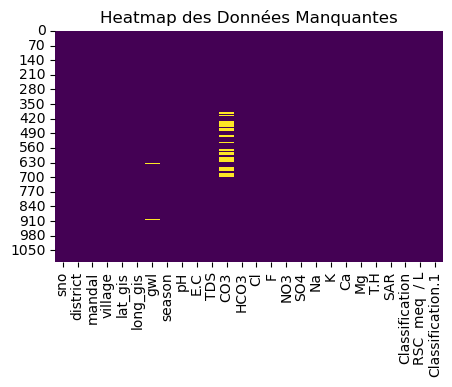

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))  # Définir la taille de la figure
sns.heatmap(df.isna(), cbar=False, cmap="viridis")
plt.title("Heatmap des Données Manquantes")
plt.show()

In [16]:
#Liste les colonnes par ordre alphabétiques avec le nombre de valeurs manquantes et le type de données
pd.concat([df.isna().sum(), df.dtypes], axis=1, keys=['isna', 'Dtype']).sort_index().reset_index()

,index,isna,Dtype
0,CO3,160,float64
1,Ca,0,float64
2,Cl,0,int64
3,Classification,0,object
4,Classification.1,0,object
5,E.C,0,int64
6,F,0,float64
7,HCO3,0,float64
8,K,0,float64
9,Mg,0,float64


In [18]:
df.select_dtypes(include=['object']).columns.tolist()
df = df.drop(['district','mandal','village','season','Classification.1'], axis=1)

In [20]:
#Parcours et affiche les variables qui ne peuvent être converties en float
for value in df['pH'].unique():
    try:
        float(value)
    except:
        print(value)

8..05


In [22]:
df['pH'] = df['pH'].replace('8..05', '8.05')
df['pH'] = df['pH'].astype(float)
df['pH'].dtype


dtype('float64')

In [24]:
df['CO3'].value_counts()
df['CO3'].fillna(df['CO3'].mean(), inplace=True)
df['gwl'].value_counts()
df['gwl'].fillna(df['gwl'].mean(), inplace=True)

In [26]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
threshold = 1.5
outliers = df[(df < (Q1 - threshold*IQR)) | (df > (Q3 + threshold*IQR))].stack().index.tolist()

TypeError: unsupported operand type(s) for -: 'str' and 'str'

### Imputation valeurs manquantes pour 'CO3' et 'gwl'

In [28]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# Sélectionner toutes les colonnes sauf "Classification"
columns_to_impute = df.columns.difference(["Classification"])

# Supprimer les lignes avec des valeurs manquantes pour avoir un jeu de données de référence
df_cleaned = df.dropna(subset=columns_to_impute)

# Diviser les données en variables caractéristiques (X) et cible (y)
X = df_cleaned[columns_to_impute]
y = df_cleaned["gwl"]

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Imputation par la moyenne
imputer_mean = SimpleImputer(strategy="mean")
X_train_imputed_mean = imputer_mean.fit_transform(X_train)
X_test_imputed_mean = imputer_mean.transform(X_test)

# Imputation multiple avec IterativeImputer et modèle RandomForestRegressor
imputer_iterative = IterativeImputer(estimator=RandomForestRegressor(), random_state=42)
X_train_imputed_iterative = imputer_iterative.fit_transform(X_train)
X_test_imputed_iterative = imputer_iterative.transform(X_test)

# Entraîner un modèle de prédiction sur les données imputées par la moyenne
model_mean = RandomForestRegressor(random_state=42)
model_mean.fit(X_train_imputed_mean, y_train)
score_mean = model_mean.score(X_test_imputed_mean, y_test)
print(f"Score avec imputation par la moyenne : {score_mean}")

# Entraîner un modèle de prédiction sur les données imputées de manière itérative
model_iterative = RandomForestRegressor(random_state=42)
model_iterative.fit(X_train_imputed_iterative, y_train)
score_iterative = model_iterative.score(X_test_imputed_iterative, y_test)
print(f"Score avec imputation itérative : {score_iterative}")

Score avec imputation par la moyenne : 0.9997993327746113
Score avec imputation itérative : 0.9997993327746113


In [30]:
# Créer un dictionnaire de mappage pour renommer les valeurs
selection = {
    'C2S1': 'Moderate',
    'C3S1': 'Poor',
    'C4S2': 'Bad',
    'C4S1': 'Bad',
    'C3S2': 'Poor',
    'C4S4': 'Bad',
    'C4S3': 'Bad',
    'C1S1': 'Good',
    'C3S4': 'Bad',
    'C3S3': 'Poor',
    'C2S2': 'Moderate'
}

# Remplacer les valeurs dans la colonne 'Classification'
df['Classification'] = df['Classification'].replace(selection)

# Supprimer les lignes contenant d'autres valeurs dans la colonne 'Classification'
df = df[df['Classification'].isin(selection.values())]

df['Classification'].value_counts()

Classification
Poor        714
Moderate    249
Bad         136
Good          3
Name: count, dtype: int64

In [32]:
from sklearn.preprocessing import LabelEncoder

# Créer une instance de LabelEncoder
le= LabelEncoder()

# Appliquer le label encoding à la colonne 'Classification'
df['Classification_encoded'] = le.fit_transform(df['Classification'])

# Calculer la matrice de corrélation avec la nouvelle colonne encodée
correlation_matrix = df.corr(numeric_only=True)

# Obtenir les corrélations par rapport à la colonne encodée
correlation_with_encoded_classification = correlation_matrix['Classification_encoded']

# Trier les corrélations par ordre décroissant et obtenir les 10 plus grandes corrélations (en excluant la corrélation avec elle-même)
correlation_with_encoded_classification.abs().sort_values(ascending=False)[1:11]

C:\Users\varsh\AppData\Local\Temp\ipykernel_20876\1978061613.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Classification_encoded'] = le.fit_transform(df['Classification'])


Cl               0.516491
TDS              0.515528
E.C              0.515528
Na               0.449197
T.H              0.393487
NO3              0.388473
Mg               0.352239
RSC  meq  / L    0.330860
Ca               0.295902
SAR              0.279272
Name: Classification_encoded, dtype: float64

In [34]:
corre_df = df[['TDS', 'E.C', 'Na', 'Cl', 'T.H', 'HCO3', 'Mg', 'SAR', 'NO3', 'Ca']]
corre_df.describe()

,TDS,E.C,Na,Cl,T.H,HCO3,Mg,SAR,NO3,Ca
count,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000
mean,861.921452,1346.752269,120.921765,190.453721,417.851983,299.102710,50.764973,2.722132,74.818648,83.696189
std,526.819814,823.155959,103.307066,190.242861,262.720824,131.326806,38.469299,2.699370,97.160428,64.470921
min,131.200000,205.000000,5.076154,10.000000,39.991776,30.000000,4.862000,0.181178,0.097438,1.200000
25%,500.000000,781.250000,55.645000,60.000000,239.967105,200.000000,24.310000,1.351652,17.727073,40.000000
50%,751.040000,1173.500000,93.000000,130.000000,359.925987,290.000000,38.896000,2.061658,41.652732,64.000000
75%,1066.720000,1666.750000,151.600000,260.000000,519.897204,378.866746,68.068000,3.163959,95.888857,104.000000
max,6079.360000,9499.000000,748.100000,2480.000000,3479.226974,1070.000000,457.028000,31.435063,1028.000000,640.000000


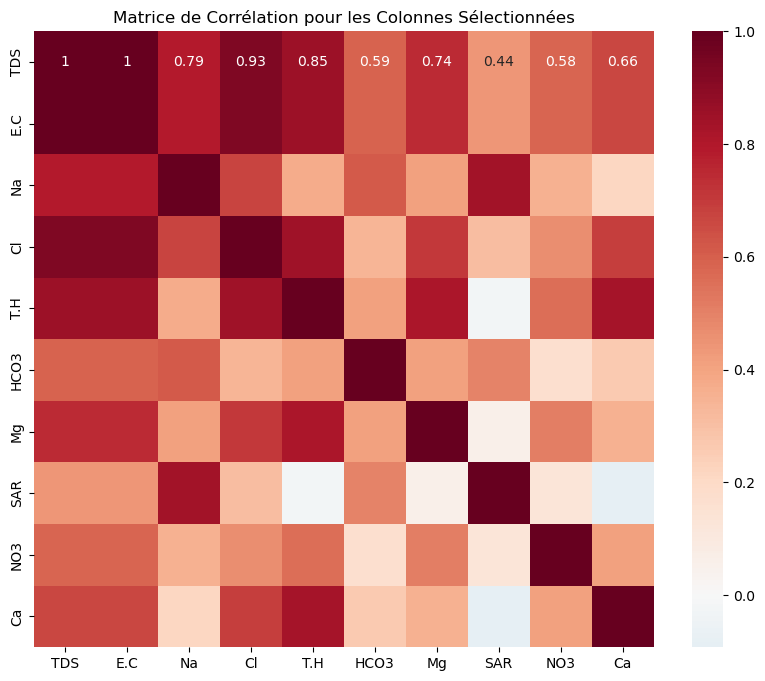

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculer la matrice de corrélation pour le nouveau DataFrame
correlation_matrix_waterqual = corre_df.corr()

# Créer une heatmap de la matrice de corrélation pour les colonnes sélectionnées
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_waterqual, annot=True, center=0, cmap='RdBu_r')
plt.title("Matrice de Corrélation pour les Colonnes Sélectionnées")
plt.show()

In [38]:
df =df[['TDS', 'E.C', 'Na', 'Cl', 'T.H', 'HCO3', 'Mg', 'SAR', 'NO3', 'Ca', 'Classification']]

Cross-validation scores: [0.98642534 0.99547511 0.99090909 0.99545455 0.99545455]
Mean CV score: 0.992743726861374
Classification Report:
               precision    recall  f1-score   support

         Bad       1.00      1.00      1.00       136
        Good       1.00      1.00      1.00         3
    Moderate       1.00      1.00      1.00       249
        Poor       1.00      1.00      1.00       714

    accuracy                           1.00      1102
   macro avg       1.00      1.00      1.00      1102
weighted avg       1.00      1.00      1.00      1102

Confusion Matrix:
 [[136   0   0   0]
 [  0   3   0   0]
 [  0   0 249   0]
 [  0   0   0 714]]


TypeError: Image data of dtype object cannot be converted to float

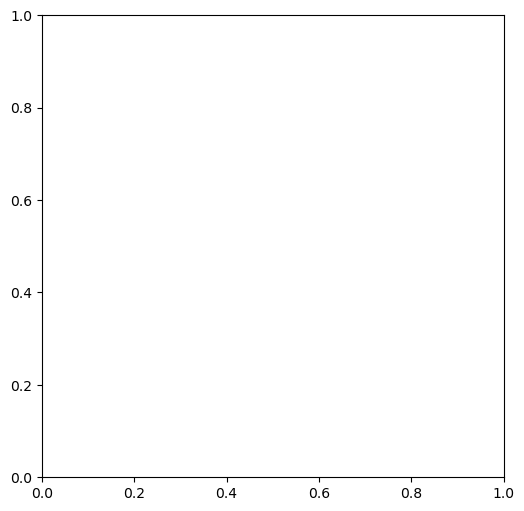

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

data = df.copy()         
# Sélectionner les caractéristiques les plus importantes
X = data.drop(columns=['Classification'])
y = data['Classification']
selector = SelectKBest(score_func=f_classif, k=10)
X_new = selector.fit_transform(X, y)

# Standardiser les caractéristiques
scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(X_new)

# Entraîner un modèle de classification (Random Forest par exemple)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# K-Fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(model, X_new_scaled, y, cv=kfold)
print("Cross-validation scores:", scores)
print("Mean CV score:", np.mean(scores))

# Entraînement final sur toutes les données d'entraînement
model.fit(X_new_scaled, y)

# Prédictions sur l'ensemble de données complet
y_pred = model.predict(X_new_scaled)

# Évaluation du modèle
print("Classification Report:\n", classification_report(y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
classes = np.unique(y)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Séparer les fonctionnalités (X) et la variable cible (y)
X = df.drop(columns=['Classification'])

# Encoder la variable cible
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42) #KFOLD

# Modèles d'apprentissage à tester
models = [
    RandomForestClassifier(),
    SVC()
]

# Boucle à travers les modèles, entraîner et évaluer
for model in models:
    model_name = model.__class__.__name__
    
    # Entraîner le modèle
    model.fit(X_train, y_train)
    
    # Prédire les étiquettes
    y_pred = model.predict(X_test)
    
    # Calculer l'exactitude
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"{model_name} - Exactitude : {accuracy:.2f}")


RandomForestClassifier - Exactitude : 0.99
SVC - Exactitude : 0.97


In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from joblib import dump

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['Classification']),
    df['Classification'],
    test_size=0.25,
)

# Train the models
svc = SVC()
svc.fit(X_train, y_train)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Evaluate the models
y_pred_svc = svc.predict(X_test)
y_pred_rf = rf.predict(X_test)


print('Accuracy of RandomForestClassifier:', accuracy_score(y_test, y_pred_rf))
print('Precision of RandomForestClassifier:', precision_score(y_test, y_pred_rf, average='macro'))
print('Recall of RandomForestClassifier:', recall_score(y_test, y_pred_rf, average='macro'))
print('F1 score of RandomForestClassifier:', f1_score(y_test, y_pred_rf, average='macro'))

print('Accuracy of SVC:', accuracy_score(y_test, y_pred_svc))
print('Precision of SVC:', precision_score(y_test, y_pred_svc, average='macro'))
print('Recall of SVC:', recall_score(y_test, y_pred_svc, average='macro'))
print('F1 score of SVC:', f1_score(y_test, y_pred_svc, average='macro'))

# Save the models
dump(svc, 'lr.pkl')
dump(rf, 'rf.pkl')


Accuracy of RandomForestClassifier: 0.9855072463768116
Precision of RandomForestClassifier: 0.992633517495396
Recall of RandomForestClassifier: 0.9693502824858756
F1 score of RandomForestClassifier: 0.9804395893781369
Accuracy of SVC: 0.967391304347826
Precision of SVC: 0.975685234305924
Recall of SVC: 0.9459510357815443
F1 score of SVC: 0.9598545801448601


['rf.pkl']

In [46]:
from sklearn.model_selection import GridSearchCV

# Create a grid of hyperparameters to tune
params = {"C": [0.01, 0.1, 1, 10, 100]}

# Create a grid search object
grid_search = GridSearchCV(model, params, cv=7)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(grid_search.best_params_)

# Make predictions on the test data using the best model
y_pred = grid_search.best_estimator_.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


C:\Users\varsh\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=7.
  warnings.warn(


{'C': 100}
Accuracy: 0.9782608695652174


              precision    recall  f1-score   support

         Bad       1.00      0.93      0.96        40
    Moderate       1.00      0.95      0.97        59
        Poor       0.97      1.00      0.98       177

    accuracy                           0.98       276
   macro avg       0.99      0.96      0.97       276
weighted avg       0.98      0.98      0.98       276

Confusion Matrix:
 [[ 37   0   3]
 [  0  56   3]
 [  0   0 177]]


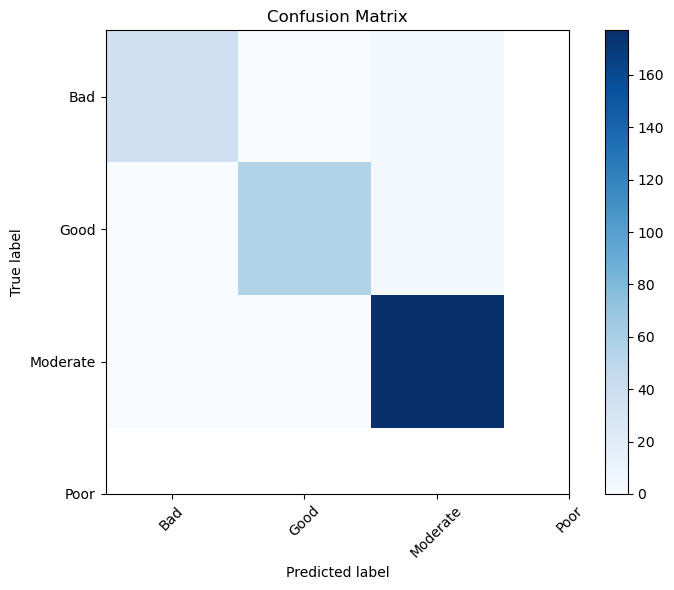

In [48]:
# Rapport de classification et matrice de confusion
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
classes = np.unique(y)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

C:\Users\varsh\AppData\Local\Temp\ipykernel_20876\658217450.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(x='K Values', y='Accuracy', data=data, ci='sd')  # ci='sd' adds error bars


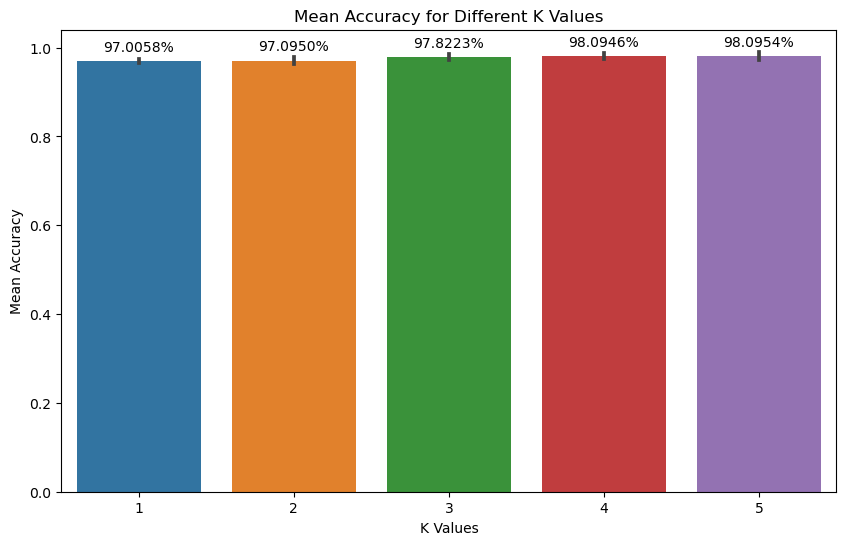

In [50]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset into the 'df' DataFrame
# df = pd.read_csv('your_dataset.csv')

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

accuracy_scores = []
k_values = []

X, y = df.drop('Classification', axis=1), df['Classification']

for train_index, test_index in kfold.split(X):
    X_train, X_test = np.array(X.iloc[train_index]), np.array(X.iloc[test_index])
    y_train, y_test = np.array(y.iloc[train_index]), np.array(y.iloc[test_index])

    for k in range(1, 6):  # Try different values of k (1 to 5)
        knn_model = KNeighborsClassifier(n_neighbors=k)
        knn_model.fit(X_train, y_train)
        y_pred = knn_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)
        k_values.append(k)

# Create a DataFrame to store the data for the plot
data = pd.DataFrame({'K Values': k_values, 'Accuracy': accuracy_scores})

# Create the Seaborn bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='K Values', y='Accuracy', data=data, ci='sd')  # ci='sd' adds error bars
plt.title('Mean Accuracy for Different K Values')
plt.xlabel('K Values')
plt.ylabel('Mean Accuracy')

# Annotate each bar with the corresponding percentage
for p in ax.patches:
    percentage = f'{p.get_height()*100:.4f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 10),
                textcoords='offset points')

plt.show()

In [52]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [1, 3, 5, 7, 9]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=kfold, scoring='accuracy')
grid_search.fit(X, y)

print('Best parameters:', grid_search.best_params_)
print('Best mean accuracy:', grid_search.best_score_)

Best parameters: {'n_neighbors': 9}
Best mean accuracy: 0.9836733854380914


              precision    recall  f1-score   support

         Bad       1.00      1.00      1.00        34
    Moderate       1.00      1.00      1.00        45
        Poor       1.00      1.00      1.00       141

    accuracy                           1.00       220
   macro avg       1.00      1.00      1.00       220
weighted avg       1.00      1.00      1.00       220

Confusion Matrix:
 [[ 34   0   0]
 [  0  45   0]
 [  0   0 141]]


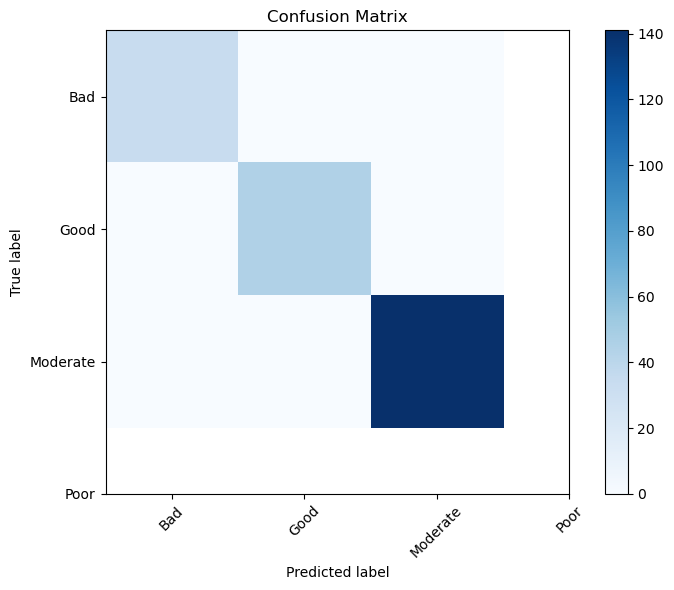

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Données X et y doivent être définies ici
X, y = df.drop('Classification', axis=1), df['Classification']

kf = KFold(n_splits=5)

# Paramètres à tester
n_estimators_list = [50, 100, 200]
max_depth_list = [None, 10, 20]
criterion_list = ['gini', 'entropy']

# Stockage des résultats pour chaque configuration
accuracy_scores_n_estimators = []
accuracy_scores_max_depth = []
accuracy_scores_criterion = []

for n_estimators in n_estimators_list:
    accuracy_scores_rf = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = np.array(X.iloc[train_index]), np.array(X.iloc[test_index])
        y_train, y_test = np.array(y.iloc[train_index]), np.array(y.iloc[test_index])

        rf_model = RandomForestClassifier(n_estimators=n_estimators)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores_rf.append(accuracy)

    average_accuracy = sum(accuracy_scores_rf) / len(accuracy_scores_rf)
    accuracy_scores_n_estimators.append(average_accuracy)

best_n_estimators_index = accuracy_scores_n_estimators.index(max(accuracy_scores_n_estimators))
best_n_estimators = n_estimators_list[best_n_estimators_index]
rf_model_best = RandomForestClassifier(n_estimators=best_n_estimators)
rf_model_best.fit(X_train, y_train)
y_pred_best = rf_model_best.predict(X_test)
cm_best = confusion_matrix(y_test, y_pred_best)

# Rapport de classification et matrice de confusion
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
classes = np.unique(y)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [56]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Données X et y doivent être définies ici

kf = KFold(n_splits=5)

# Paramètres à tester
n_estimators_list = [50, 100, 200]
max_depth_list = [None, 10, 20]
criterion_list = ['gini', 'entropy']

# Stockage des résultats pour chaque configuration
accuracy_scores_n_estimators = []
accuracy_scores_max_depth = []
accuracy_scores_criterion = []

for n_estimators in n_estimators_list:
    accuracy_scores_rf = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = np.array(X.iloc[train_index]), np.array(X.iloc[test_index])
        y_train, y_test = np.array(y.iloc[train_index]), np.array(y.iloc[test_index])

        rf_model = RandomForestClassifier(n_estimators=n_estimators)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores_rf.append(accuracy)

    average_accuracy = sum(accuracy_scores_rf) / len(accuracy_scores_rf)
    accuracy_scores_n_estimators.append(average_accuracy)

for max_depth in max_depth_list:
    accuracy_scores_rf = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = np.array(X.iloc[train_index]), np.array(X.iloc[test_index])
        y_train, y_test = np.array(y.iloc[train_index]), np.array(y.iloc[test_index])

        rf_model = RandomForestClassifier(max_depth=max_depth)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores_rf.append(accuracy)

    average_accuracy = sum(accuracy_scores_rf) / len(accuracy_scores_rf)
    accuracy_scores_max_depth.append(average_accuracy)

for criterion in criterion_list:
    accuracy_scores_rf = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = np.array(X.iloc[train_index]), np.array(X.iloc[test_index])
        y_train, y_test = np.array(y.iloc[train_index]), np.array(y.iloc[test_index])

        rf_model = RandomForestClassifier(criterion=criterion)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores_rf.append(accuracy)

    average_accuracy = sum(accuracy_scores_rf) / len(accuracy_scores_rf)
    accuracy_scores_criterion.append(average_accuracy)

print("Moyenne de précision pour différents nombres d'estimateurs:", accuracy_scores_n_estimators)
print("Moyenne de précision pour différentes profondeurs max:", accuracy_scores_max_depth)
print("Moyenne de précision pour différents critères:", accuracy_scores_criterion)

Moyenne de précision pour différents nombres d'estimateurs: [0.9945660222130812, 0.9945660222130812, 0.9936569313039902]
Moyenne de précision pour différentes profondeurs max: [0.9936569313039902, 0.9927478403948993, 0.9945660222130812]
Moyenne de précision pour différents critères: [0.9936569313039902, 0.9945660222130812]


In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
best_score = 0
best_params = {}
best_accuracy = 0
best_precision = 0
best_recall = 0
best_f1_score = 0
# RandomForestClassifier with different n_estimators, max_depth, and min_samples_split
for n_estimators in [100, 200]:
    for max_depth in [None, 3]:
        for min_samples_split in [2, 5]:
            clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
            scores = []
            precisions = []
            recalls = []
            f1_scores = []
            confusion_matrices = []
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]
                clf.fit(X_train, y_train)  # fit the classifier on the training data
                scores.append(accuracy_score(y_test, clf.predict(X_test)))
                precisions.append(precision_score(y_test, clf.predict(X_test), average='weighted', zero_division=1))
                recalls.append(recall_score(y_test, clf.predict(X_test), average='weighted'))
                f1_scores.append(f1_score(y_test, clf.predict(X_test), average='weighted'))
                confusion_matrices.append(confusion_matrix(y_test, clf.predict(X_test)))
            mean_score = np.mean(scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = {'n_estimators': n_estimators, 'max_depth': max_depth, 'min_samples_split': min_samples_split}
                best_confusion_matrix = confusion_matrices[np.argmax(scores)]
                best_accuracy = np.mean(scores)
                best_precision = np.mean(precisions)
                best_recall = np.mean(recalls)
                best_f1_score = np.mean(f1_scores)
print("="*40)
print(clf.__class__.__name__)
print("="*40)
print(f"Best parameters: {best_params}")
print("="*40)
print("mean accuracy: {:.4f}".format(best_accuracy))
print("mean precision: {:.4f}".format(best_precision))
print("mean recall: {:.4f}".format(best_recall))
print("mean f1 score: {:.4f}".format(best_f1_score))
print("="*40)
print("confusion matrix:")
print(best_confusion_matrix)
print("="*40)

RandomForestClassifier
Best parameters: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 5}
mean accuracy: 0.9937
mean precision: 0.9937
mean recall: 0.9937
mean f1 score: 0.9927
confusion matrix:
[[ 26   0   0   0]
 [  0   1   0   0]
 [  0   0  41   0]
 [  0   0   0 152]]


In [59]:
df.describe()

,TDS,E.C,Na,Cl,T.H,HCO3,Mg,SAR,NO3,Ca
count,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000,1102.000000
mean,861.921452,1346.752269,120.921765,190.453721,417.851983,299.102710,50.764973,2.722132,74.818648,83.696189
std,526.819814,823.155959,103.307066,190.242861,262.720824,131.326806,38.469299,2.699370,97.160428,64.470921
min,131.200000,205.000000,5.076154,10.000000,39.991776,30.000000,4.862000,0.181178,0.097438,1.200000
25%,500.000000,781.250000,55.645000,60.000000,239.967105,200.000000,24.310000,1.351652,17.727073,40.000000
50%,751.040000,1173.500000,93.000000,130.000000,359.925987,290.000000,38.896000,2.061658,41.652732,64.000000
75%,1066.720000,1666.750000,151.600000,260.000000,519.897204,378.866746,68.068000,3.163959,95.888857,104.000000
max,6079.360000,9499.000000,748.100000,2480.000000,3479.226974,1070.000000,457.028000,31.435063,1028.000000,640.000000


In [60]:
df.to_csv(output_path, index=False)